In [185]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import get_recording_time,plot_probe, assign_DIO_times_to_trials, Trim_TTLs, select_DIO_sync_trial_trace, stitch_bpod_times, select_DIO_channel, find_min_distance_TTL, extract_time, extract_analogIO, check_single_rec_file, extract_DIO, check_timestamp_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
import spikeinterface.full as si
from spikeinterface.preprocessing import detect_bad_channels
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import panel as pn

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Ott lab process single session**
#####  Multi-Neuropixels recording using SpikeGadgets + Bpod

# Select file

In [237]:
# folder containing .rec file
path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/")


In [238]:
mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)
time = get_recording_time(path_recording_folder)
print(f"mouse {mouse_n} recorded on {day} at {time}")

mouse 12 recorded on 20231212 at 18:35:52


In [128]:
path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

Exactly one .rec file found: 20231212_183552.rec


In [130]:
# Load in spikeinterface
raw_rec = read_spikegadgets(path_recording)
fs = raw_rec.get_sampling_frequency()

In [131]:
print(f"Recording duration in minutes: {raw_rec.get_total_duration()/60}, sampling rate: {fs} Hz")
print(f"Probes present: {raw_rec.get_probes()}")

Recording duration in minutes: 154.06692055555555, sampling rate: 30000.0 Hz
Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]


# Sync Bpod and Trodes streams

### Export Digital IO channels

In [132]:
%%time
#check if already available, if not extract
extract_DIO(path_recording_folder, path_recording) # TODO what is timestampoffset?

'.DIO' folder alread available: 20231212_183552.DIO
CPU times: user 508 µs, sys: 0 ns, total: 508 µs
Wall time: 602 µs


In [270]:
DIO_timestamps_start_trial, DIO_samples_start_trial = select_DIO_sync_trial_trace(path_recording_folder, rec_file_name)

20231212_183552.dio_Controller_Din1.dat contains data
1 DIO files with data


/alzheimer/Roberto/Github/spikesorting/Utils/TrodesToPython/readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


## load bpod mat file behavior

In [271]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , path_recording_folder)

.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231212_181618/12_AuditoryTuning_20231212_181618.mat
Bpod file starts after recording start
.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231212_185101/12_DetectionConfidence_20231212_185101.mat
Bpod file starts after recording start


/alzheimer/Roberto/Dariya/12/bpod_session/20231212_181618/12_AuditoryTuning_20231212_181618.mat
Bpod session started at 18:36:24, duration: 12.826175000000001 min, ended at: 18:49:13
Extracting AuditoryTuning params
/alzheimer/Roberto/Dariya/12/bpod_session/20231212_185101/12_DetectionConfidence_20231212_185101.mat
Bpod session started at 18:51:30, duration: 137.31311333333332 min, ended at: 21:08:48
Extracting DetectionConfidence params
CPU times: user 438 ms, sys: 11.4 ms, total: 449 ms
Wall time: 462 ms


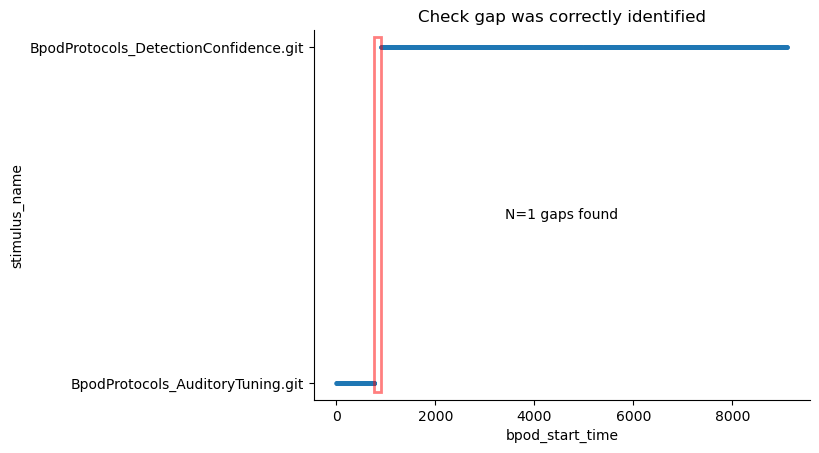

In [272]:
%%time
trials =  stitch_bpod_times(bpod_file, day, DIO_timestamps_start_trial)
# trodes rec never startts during a bpod file
# check for three behav 
# check gaps mouse 12 20240126
# check gaps mouse 13 20231212

The most distant pulse in array1 is at index 1399 with time 9121.225866666666
This pulse has a minimum distance of 12.271066665649414 to the closest pulse in array2


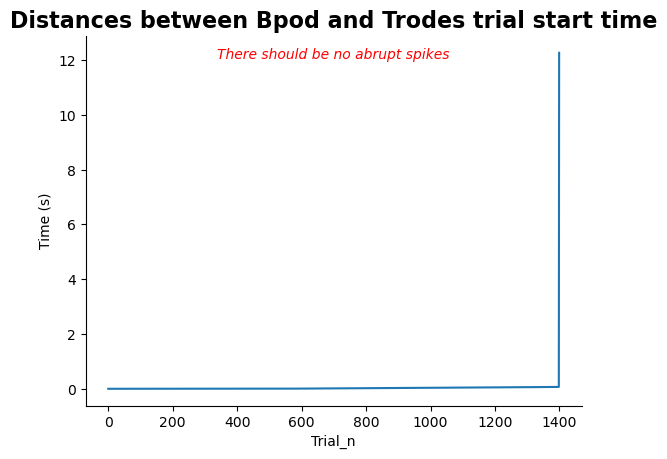

In [273]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

In [274]:
# only adapted to case where there is a extra TTL in the DIO at the end of last stimulus block!
DIO_timestamps_start_trial,  DIO_samples_start_trial = Trim_TTLs(trials, DIO_timestamps_start_trial, DIO_samples_start_trial,min_distances)

unequal numbers of trials between bpod and DIO
One extra TTL pulse received on DIO at the end of the session
extra TTL pulse removed


The most distant pulse in array1 is at index 1398 with time 9109.022966666666
This pulse has a minimum distance of 0.06816666573286057 to the closest pulse in array2


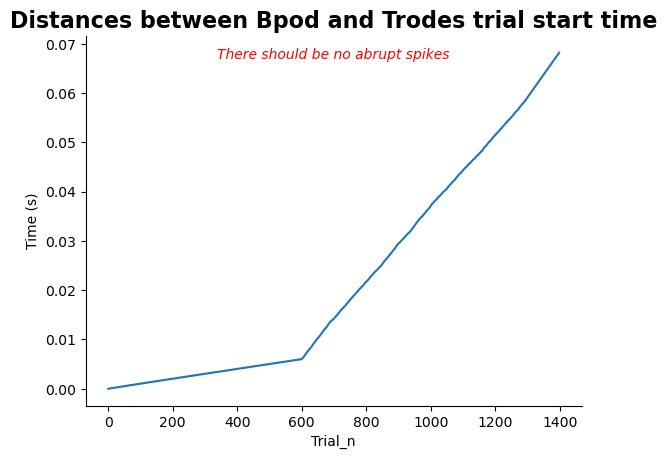

In [275]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

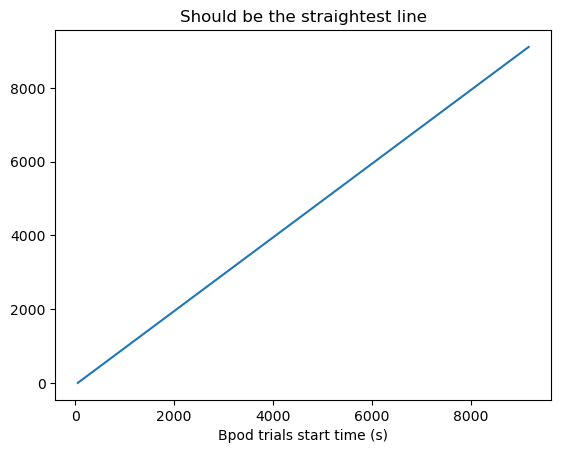

In [276]:
trials = assign_DIO_times_to_trials(trials, DIO_timestamps_start_trial, DIO_samples_start_trial)

In [277]:
%%time
# assign trodes times
times = raw_rec.get_times()
trials["start_time"] = times[trials["DIO_start_sample_zeroed"]]
trials

CPU times: user 577 ms, sys: 1.51 s, total: 2.09 s
Wall time: 2.09 s


,bpod_start_time,bpod_stop_time,stimulus_block,stimulus_name,Frequency,Volume,AfterTrialInterval,BeforeTrialInterval,Beta,BiasVersion,...,SignalDuration,SignalVolume,StimDuration,WaitingTime,StimulusStartTime,RewardStartTime,DIO_start_sample,DIO_start_time,DIO_start_sample_zeroed,start_time
0,1.1802,2.3802,0,BpodProtocols_AuditoryTuning.git,500.0,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1591690,53.056333,0,0.000000
1,2.4890,3.6890,0,BpodProtocols_AuditoryTuning.git,1000.0,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1630955,54.365167,39265,1.308833
2,3.7490,4.9490,0,BpodProtocols_AuditoryTuning.git,1500.0,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1668755,55.625167,77065,2.568833
3,5.0100,6.2100,0,BpodProtocols_AuditoryTuning.git,2000.0,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1706585,56.886167,114895,3.829833
4,6.2691,7.4691,0,BpodProtocols_AuditoryTuning.git,2500.0,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1744358,58.145267,152668,5.088933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,9061.3978,9062.5978,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.262862,1.0,...,0.1,37.885858,0.1,NaN,NaN,NaN,273400252,9113.341733,271808562,9060.285400
1395,9073.5830,9074.7830,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.802172,1.0,...,0.1,54.065175,0.1,NaN,NaN,NaN,273765811,9125.527033,272174121,9072.470700
1396,9085.7843,9086.9843,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.519861,1.0,...,0.1,45.595840,0.1,NaN,NaN,NaN,274131853,9137.728433,272540163,9084.672100
1397,9097.9691,9099.1691,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.108620,1.0,...,0.1,33.258611,0.1,NaN,NaN,NaN,274497400,9149.913333,272905710,9096.857000


# Spike sorting

## Pre-processing

### Highpass filter

In [142]:
rec_filt = si.highpass_filter(raw_rec, freq_min=300.)

### Detect bad channels

In [143]:
%%time
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = detect_bad_channels(rec_filt, dead_channel_threshold=-1)

CPU times: user 56 s, sys: 48.8 s, total: 1min 44s
Wall time: 2min 22s


In [144]:
# count bad channels
count = np.unique(channel_labels, return_counts=True)
if (count[0].shape[0] == 1) & (count[0][0]=="good"):
     print("no bad channels")
else:
    for n in range(count[0].shape[0]):
        print(f"{count[1][n]} {count[0][n]} channels")

no bad channels


### Inspect probes

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.bootst...)
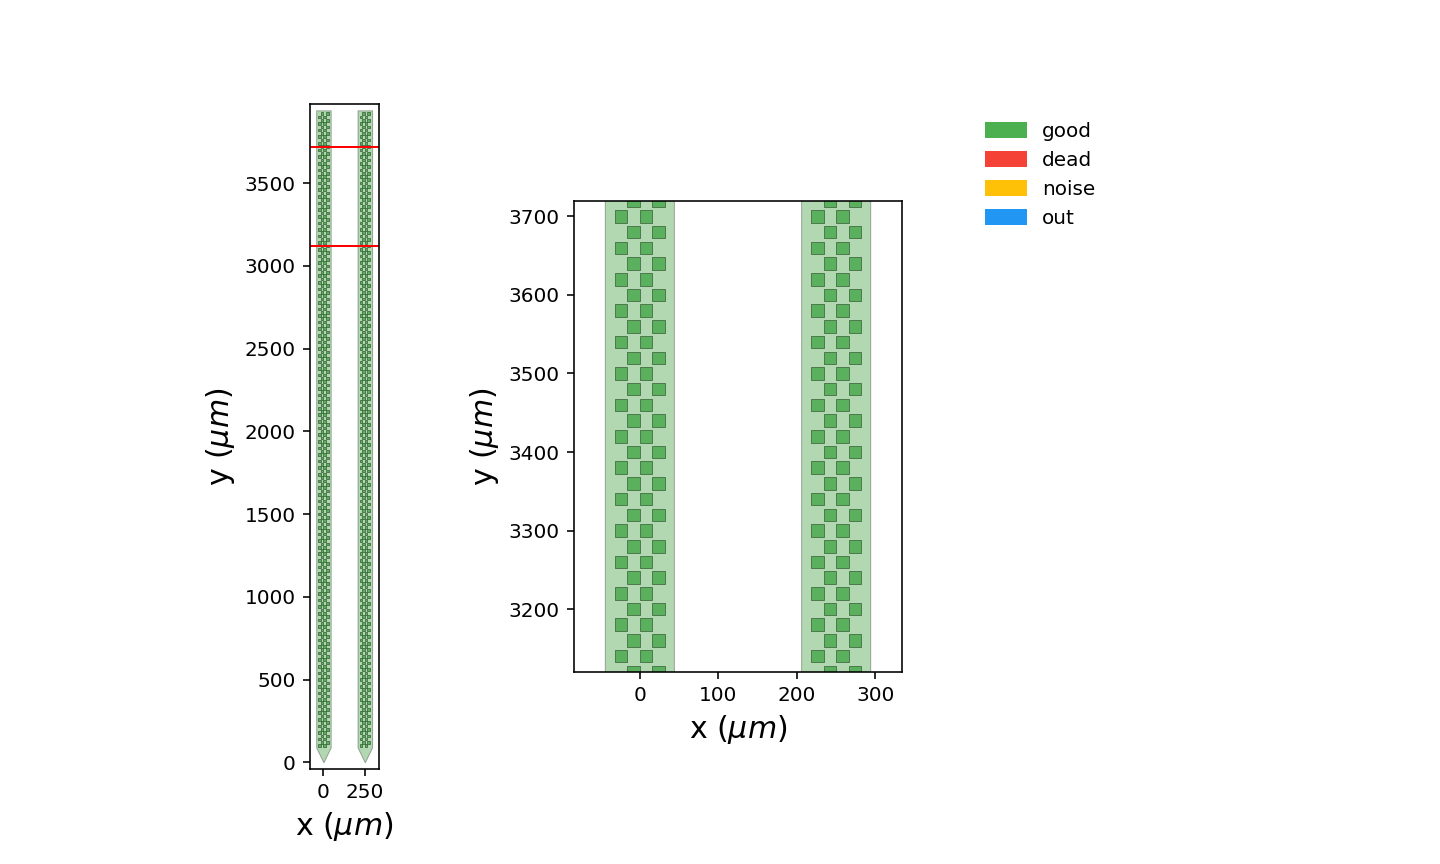

In [145]:
plot_probe(raw_rec, channel_labels)

In [ ]:
# remove bad channels
rec_filt = rec_filt.remove_channels(bad_channel_ids)
print("bad channels removed")

## Sorting

In [102]:
%%time

check_gpu_availability()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = si.run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.38s; total  7.38s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:36<00:00,  1.03it/s]


drift computed in  527.25s; total  534.63s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:34<00:00,  1.03it/s]


2660633 spikes extracted in  523.71s; total  1058.35s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [08:53<00:00,  5.56s/it]


315 clusters found, in  534.55s; total  1592.90s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:26<00:00,  1.99it/s]


3295389 spikes extracted in  267.40s; total  1860.30s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [07:54<00:00,  4.94s/it]


277 clusters found, in  474.07s; total  2334.36s

Merging clusters
274 units found, in  2.39s; total  2336.76s

Saving to phy and computing refractory periods
50 units found with good refractory periods

Total runtime: 2368.57s = 00:39:29 h:m:s
kilosort4 run time 2373.54s
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.40s; total  7.40s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:33<00:00,  1.03it/s]


drift computed in  525.22s; total  532.61s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:31<00:00,  1.04it/s]


2663568 spikes extracted in  520.47s; total  1053.08s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [09:10<00:00,  5.73s/it]


280 clusters found, in  550.92s; total  1604.01s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:16<00:00,  2.07it/s]


2707623 spikes extracted in  256.53s; total  1860.53s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [05:32<00:00,  3.46s/it]


269 clusters found, in  332.19s; total  2192.72s

Merging clusters
265 units found, in  1.66s; total  2194.38s

Saving to phy and computing refractory periods
41 units found with good refractory periods

Total runtime: 2223.44s = 00:37:3 h:m:s
kilosort4 run time 2226.19s
CPU times: user 17h 14min 18s, sys: 30min 51s, total: 17h 45min 10s
Wall time: 1h 16min 45s


## Post-processing

In [315]:
times = sorting.get_times()

In [316]:
times[sorting.get_unit_spike_train(unit_id=0)]

array([1.43600000e-01, 1.91000000e-01, 2.46000000e-01, ...,
       9.45401367e+02, 9.45416233e+02, 9.45479733e+02])

In [271]:
sorting = si.read_sorter_folder(f"{path_recording_folder}/spike_interface_output/probe{group}")

In [273]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=True, format="memory")

estimate_sparsity:   0%|          | 0/1059 [00:00<?, ?it/s]

In [291]:
job_kwargs = dict(chunk_duration='10s', progress_bar=True, n_jobs=20)

In [293]:
%%time
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms",  ms_before=1.5,ms_after=2., **job_kwargs)

compute_waveforms:   0%|          | 0/106 [00:00<?, ?it/s]

In [299]:
%%time
analyzer.compute("templates", operators=["average", "median", "std"])
analyzer.compute("noise_levels")

CPU times: user 17.5 s, sys: 1.89 s, total: 19.4 s
Wall time: 19.4 s


In [300]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']

metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names)

metrics

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


,amplitude_cutoff,firing_rate,isi_violations_ratio,isi_violations_count,presence_ratio,snr
0,0.003159,8.357617,0.108184,24.0,0.941176,1.378960
1,0.001450,13.576405,0.169115,99.0,0.941176,1.610459
2,0.009316,5.407703,0.344541,32.0,0.941176,1.318156
3,0.010244,14.413301,0.247045,163.0,0.941176,3.397470
4,0.000518,21.547691,0.888354,1310.0,0.941176,2.220658
...,...,...,...,...,...,...
269,NaN,0.062342,0.000000,0.0,0.647059,10.361514
270,0.003171,11.898837,0.582651,262.0,0.941176,4.977450
271,0.006390,20.979055,0.393466,550.0,0.941176,7.330107
272,0.001046,9.330532,0.549727,152.0,0.941176,4.409061


In [ ]:
%%time
from tqdm.notebook import tqdm
spike_times = {}
for unit_id in tqdm(sorting.unit_ids):
    spike_times[unit_id] = times[sorting.get_unit_spike_train(unit_id=0)]

In [809]:
gaps = check_timestamp_gaps(raw_rec)

No gaps detected.


### Export Analog IO channels

In [160]:
%%time
extract_analogIO(path_recording_folder, path_recording)# 55 min too slow


'.analog' folder alread available: 20231212_183552.analog
CPU times: user 553 µs, sys: 109 µs, total: 662 µs
Wall time: 770 µs


### Export timestamps

In [161]:
%%time
#extract_time(path_recording_folder, path_recording) # slower than analogIO somehow!!

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


## Load Trodes timestamps

In [174]:
path_analogIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.analog")

In [280]:
from Utils.TrodesToPython.readTrodesExtractedDataFile3 import readTrodesExtractedDataFile
analog_dict = readTrodesExtractedDataFile(Path(path_analogIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.timestamps.dat"))

NameError: name 'path_analogIO_folder' is not defined

In [178]:
analog_dict["data"].shape

(277320457,)

In [179]:
raw_rec.get_total_samples()

277320457

In [186]:
times = raw_rec.get_times()

In [188]:
times[analog_dict["data"]["time"]]

IndexError: index 277320457 is out of bounds for axis 0 with size 277320457

In [187]:
analog_dict["data"]["time"]

array([  1279032,   1279033,   1279034, ..., 278599486, 278599487,
       278599488], dtype=uint32)

In [184]:
analog_dict["first_timestamp"]

'1279032'